In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

class LossLogger(object):
    def __init__(self, decay):
        self.loss_history = []
        self.loss = 0
        self.decay = decay
        
    def push(self, loss):
        self.loss_history.append(loss)
        self.loss *= self.decay
        self.loss += loss * (1-self.decay)
        
    def loss(self):
        return self.loss
    
    def flush(self):
        self.loss = 0

    def history(self):
        return self.loss_history
    
    
logger = LossLogger(0.8)

In [2]:
args = parse_args(["--alg", "VDSR", "--point_num", "20000", "--description", "psnr+ssim+20000pts+celeba", "--lr", "1e-4", "--epoch", "200", '--data_root', 'data/celeba'])

In [3]:
# Training Preparation
utils.set_seed_everywhere(args.seed)

device = torch.device('cuda:0' if args.device == 'gpu' and torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = utils.TrainDataset(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

loss_function = nn.MSELoss()

# loss_function = lambda img_gt, img_pred : -utils.psnr(img_gt, img_pred) - utils.ssim(img_gt, img_pred)

model = utils.make_model(args).to(device)
model = model.float()

optimizer = optim.RAdam(params=model.parameters(),lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10000,gamma = 0.4)

e = 0

cuda:0


In [4]:
print(len(train_loader))

45585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


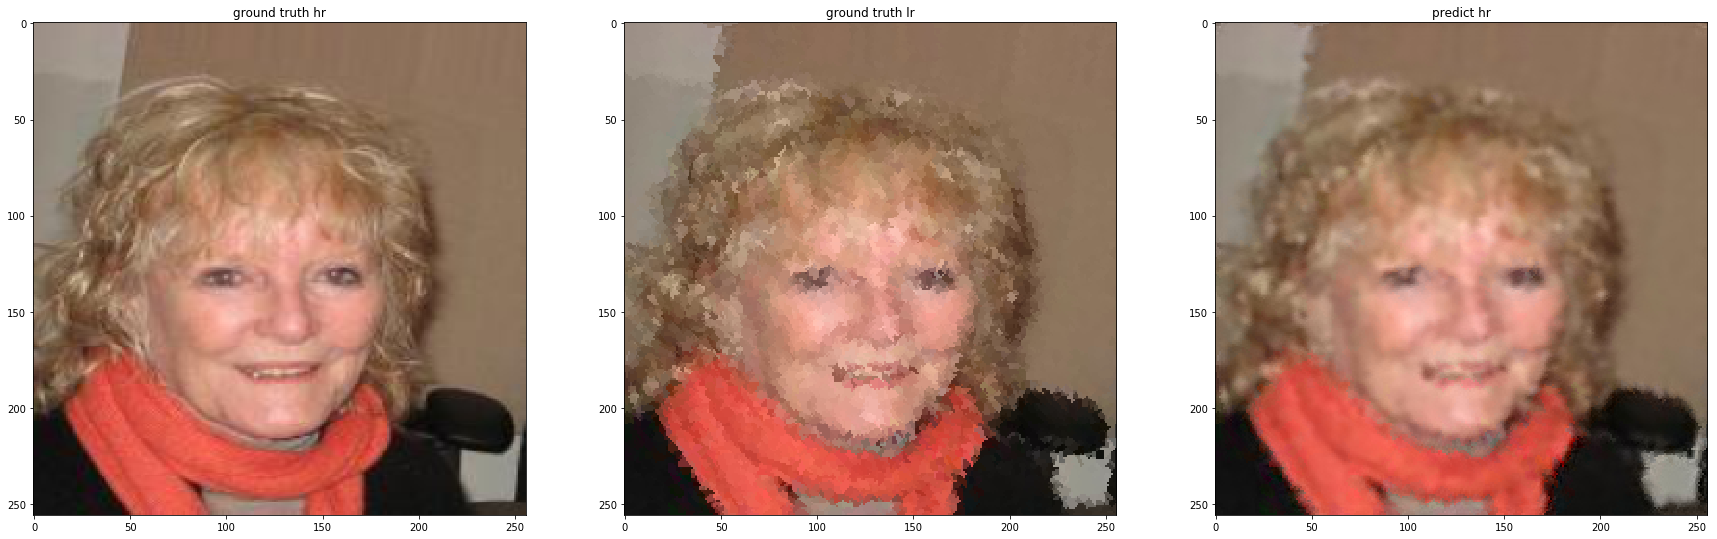

epoch: 0 | idx: 950/45585 | loss: -1.0888453277783063 | psnr: 77.81694793701172 | ssim: 0.869069516658783


KeyboardInterrupt: 

In [5]:
# Start training
lr_list = []
model.train()

for _ in range(2):
    # train_loader = tqdm.tqdm(train_loader)
    for idx, img_pair in enumerate(train_loader):
        
        img_hr = img_pair['hr'].to(device)
        img_lr = img_pair['lr'].to(device)
        
        if args.alg == 'CNF':
            img_predict, loss = model(x_hr=img_hr, xlr=img_lr)
        else:
            img_predict = model(img_lr)
            # loss = loss_function(img_hr, img_predict)
            psnr = utils.psnr(img_hr, img_predict)
            ssim = utils.ssim(img_hr, img_predict)
            loss = -psnr/300 - ssim
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        logger.push(loss.item())
        if idx % 10 == 0:
            clear()
            utils.show_gt_and_pred(img_hr=img_hr[0].permute(1,2,0).cpu(), img_lr=img_lr[0].permute(1,2,0).cpu(), pred_hr=img_predict[0].permute(1,2,0).detach().cpu(), figsize=(30, 30))
        # train_loader.set_description(f"epoch: {e} | idx: {idx} | loss: {logger.loss}")
            print(f"epoch: {e} | idx: {idx}/{len(train_loader)} | loss: {logger.loss} | psnr: {psnr} | ssim: {ssim}")


    utils.save_model(model, e, args)
    e += 1

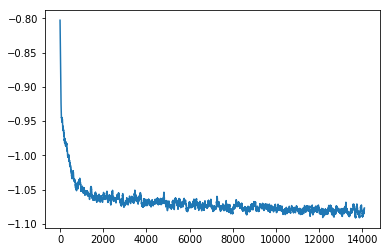

In [ ]:
# todo: equivalent to 130,000 batches or about 10 epochs.

loss_history = logger.history()
kernel = np.ones((50))/50

smooth_history = np.convolve(loss_history, kernel, mode='valid')
# plt.plot(lr_list)
plt.plot(smooth_history)
plt.show()
# print((lr_list))

TypeError: 'DataLoader' object is not subscriptable

/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Untyped global name 'isinstance': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "sampling/triangulation_blur.py", line 100:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <source elided>
        raise Exception('Img can not be None.')
    if not isinstance(img, np.ndarray):
    ^

  @nb.jit()
/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Unsupported constraint encountered: raise $14call_function.2

File "sampling/triangulation_blur.py", line 99:
def DelaunayTriangulationBlur(img, point_num=1000, method="center")

torch.Size([256, 256, 3])
torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3]) torch.Size([256, 256, 3]) torch.Size([256, 256, 3])


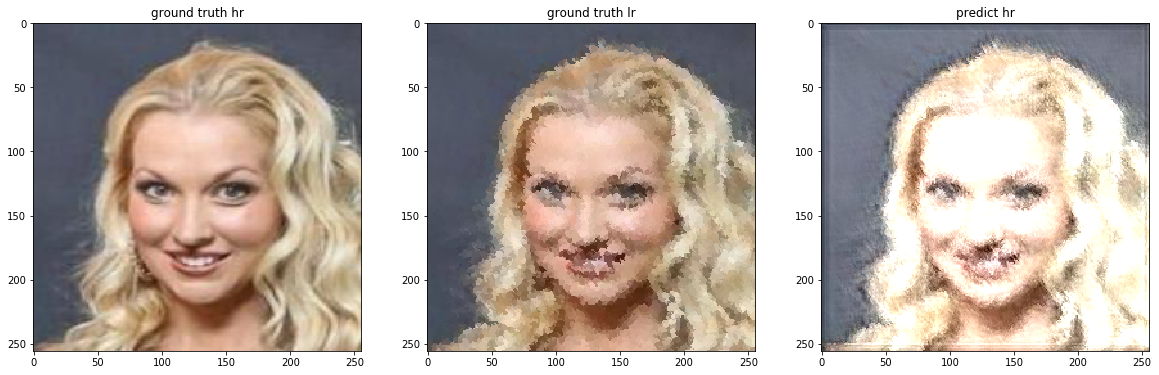

In [ ]:
import random

img_pair = train_dataset[random.randint(0, len(train_dataset)-1)]
model.eval()
img_hr, img_lr = img_pair
img_hr = img_pair['hr']
img_lr = img_pair['lr']
print(img_lr.shape)
img_pred = model(img_lr.unsqueeze(0).permute(0, 3,1,2).to(device))
print(img_pred.shape)

# img_hr = img_hr.permute(1,2,0).cpu()
# img_lr = img_lr.permute(1,2,0).cpu()
img_pred = img_pred.squeeze(0).permute(1,2,0).detach().cpu()

print(img_hr.shape, img_lr.shape, img_pred.shape)
utils.show_gt_and_pred(img_lr=img_lr, img_hr=img_hr, pred_hr=img_pred, figsize=(20, 20))

In [ ]:
import os

save_path = os.path.join(args.log_dir, args.alg+'_'+args.description+'_'+'0-epoch-14143-iter'+'.pth')
torch.save(model.state_dict(), save_path)

In [ ]:
img = train_dataset[0]['hr'].numpy()
print(type(img), img.shape)
utils.DelaunayTriangulationBlur(img, 10000).shape

<class 'numpy.ndarray'> (256, 256, 3)


/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Untyped global name 'isinstance': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "sampling/triangulation_blur.py", line 100:
def DelaunayTriangulationBlur(img, point_num=1000, method="center"):
    <source elided>
        raise Exception('Img can not be None.')
    if not isinstance(img, np.ndarray):
    ^

  @nb.jit()
/home/purewhite/workspace/cg-proj/NUG-DLSS/sampling/triangulation_blur.py:90: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "DelaunayTriangulationBlur" failed type inference due to: Unsupported constraint encountered: raise $14call_function.2

File "sampling/triangulation_blur.py", line 99:
def DelaunayTriangulationBlur(img, point_num=1000, method="center")

(256, 256, 3)